#CN Project
#Members
#Izaan Mujeeb 22k-4635
#Anas Shoaib 22k-4592
#Project : DNS Resolver & Query Analyzer

In [ ]:
pip install dnspython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
pip install scapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 12.6 MB/s eta 0:00:00


#Response Time Calulation For Records

In [ ]:
import dns.resolver
import time

def dns_query(domain, record_type='A'):
    resolver = dns.resolver.Resolver()
    resolver.timeout = 2
    resolver.lifetime = 4

    print(f"\nQuerying {record_type} record for domain: {domain}")
    print(f"Using DNS Server(s): {resolver.nameservers}")

    start_time = time.time()
    try:
        answers = resolver.resolve(domain, record_type)
        end_time = time.time()
        response_time_ms = (end_time - start_time) * 1000

        print(f"\n--- Response ---")
        for rdata in answers:
            print(f"{record_type} Record: {rdata.to_text()}")
        print(f"Response Time: {response_time_ms:.2f} ms")

    except Exception as e:
        print(f"DNS query failed: {e}")

dns_query("google.com", "NS")



Querying NS record for domain: google.com
Using DNS Server(s): ['127.0.0.11']

--- Response ---
NS Record: ns1.google.com.
NS Record: ns4.google.com.
NS Record: ns2.google.com.
NS Record: ns3.google.com.
Response Time: 8.07 ms


#Simulation And Analyzation Of Hops

In [ ]:
import dns.message
import dns.query
import dns.name
import dns.rdatatype

ROOT_SERVERS = [
    '198.41.0.4',
    '199.9.14.201',
    '192.33.4.12',
    '199.7.91.13',
]

def query_server(server, domain, rdtype='A'):
    try:
        query = dns.message.make_query(domain, rdtype)
        response = dns.query.udp(query, server, timeout=2)
        return response
    except Exception as e:
        print(f" Error querying {server}: {e}")
        return None

def iterative_resolve(domain_name):
    domain = dns.name.from_text(domain_name)
    current_servers = ROOT_SERVERS
    hop_count = 1

    while True:
        for server in current_servers:
            print(f"Hop {hop_count}: Queried {server} for {domain}")
            response = query_server(server, domain)

            if not response:
                continue

            if response.answer:
                print("Final Answer:")
                for ans in response.answer:
                    print(ans)
                return

            next_servers = []
            for rr in response.additional:
                if rr.rdtype == dns.rdatatype.A:
                    for item in rr.items:
                        next_servers.append(item.address)

            if next_servers:
                current_servers = next_servers
                break
            else:
                print(" No further referral IPs found.")
                return

        hop_count += 1

iterative_resolve("google.com")


Hop 1: Queried 198.41.0.4 for google.com.
Hop 2: Queried 192.41.162.30 for google.com.
Hop 3: Queried 216.239.34.10 for google.com.
Final Answer:
google.com. 300 IN A 142.251.8.100
google.com. 300 IN A 142.251.8.101
google.com. 300 IN A 142.251.8.139
google.com. 300 IN A 142.251.8.113
google.com. 300 IN A 142.251.8.102
google.com. 300 IN A 142.251.8.138


#Calculating Response Time Per Hop

In [ ]:
import time
import dns.message
import dns.query
import dns.name
import dns.rdatatype
from google.colab import files

ROOT_SERVERS = [
    '198.41.0.4',
    '199.9.14.201',
    '192.33.4.12',
    '199.7.91.13',
]

def query_server_with_time(server, domain, rdtype='A'):
    start_time = time.time()  # Start time for tracking response time
    try:
        query = dns.message.make_query(domain, rdtype)
        response = dns.query.udp(query, server, timeout=2)
        end_time = time.time()  # End time
        response_time = end_time - start_time  # Calculate response time
        return response, response_time
    except Exception as e:
        print(f"Error querying {server}: {e}")
        return None, None

def save_to_csv(hop_data, filename='dns_hops.csv'):
      with open(filename, mode='w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=['Hop', 'DNS Server IP', 'Response Time (s)', 'Final Answer'])
        writer.writeheader()
        for data in hop_data:
            writer.writerow(data)
        files.download('hops.csv')

def track_response_time_per_hop(domain_name):
    domain = dns.name.from_text(domain_name)
    current_servers = ROOT_SERVERS
    hop_count = 1

    while True:
        for server in current_servers:
            print(f"Hop {hop_count}: Querying {server} for {domain}")
            response, response_time = query_server_with_time(server, domain)

            if response is None:
                print(f"Failed to get response from {server}")
                continue

            print(f"Response Time for Hop {hop_count}: {response_time:.4f} seconds")

            if response.answer:
                print("Final Answer:")
                for ans in response.answer:
                    print(ans)
                return

            next_servers = []
            for rr in response.additional:
                if rr.rdtype == dns.rdatatype.A:
                    for item in rr.items:
                        next_servers.append(item.address)

            if next_servers:
                current_servers = next_servers
                break
            else:
                print("No further referral IPs found.")
                return

        hop_count += 1

track_response_time_per_hop("google.com")


Hop 1: Querying 198.41.0.4 for google.com.
Response Time for Hop 1: 0.0428 seconds
Hop 2: Querying 192.41.162.30 for google.com.
Response Time for Hop 2: 0.1317 seconds
Hop 3: Querying 216.239.34.10 for google.com.
Response Time for Hop 3: 0.0030 seconds
Final Answer:
google.com. 300 IN A 142.251.8.113
google.com. 300 IN A 142.251.8.100
google.com. 300 IN A 142.251.8.139
google.com. 300 IN A 142.251.8.102
google.com. 300 IN A 142.251.8.138
google.com. 300 IN A 142.251.8.101


#Visualization Of Response Time Per Hops

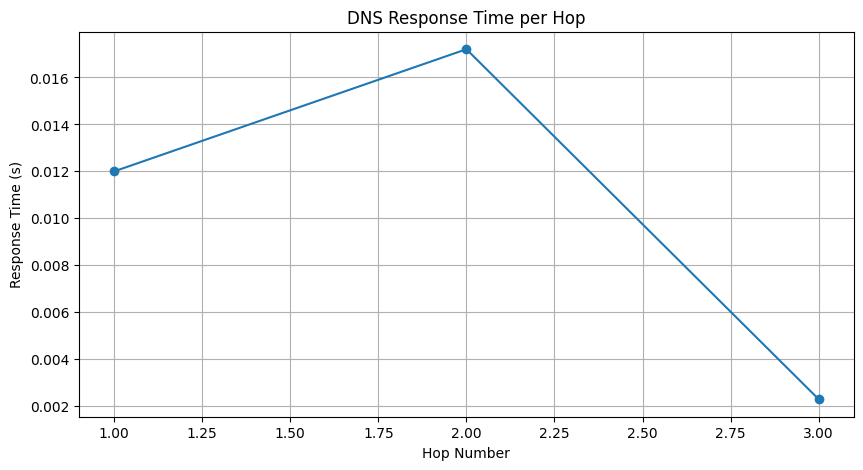

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('dns_hops.csv')

plt.figure(figsize=(10, 5))
plt.plot(df['Hop'], df['Response Time (s)'], marker='o')
plt.title('DNS Response Time per Hop')
plt.xlabel('Hop Number')
plt.ylabel('Response Time (s)')
plt.grid(True)
plt.show()


#Recursive Queries For Comparing Of Multiple DNS Resolvers

In [ ]:
import time
import dns.resolver

providers = {
    'Google DNS': '8.8.8.8',
    'Cloudflare': '1.1.1.1',
    'OpenDNS': '208.67.222.222',
    'Quad9': '9.9.9.9',
}

domain = 'openai.com'
results = []

for name, ip in providers.items():
    resolver = dns.resolver.Resolver()
    resolver.nameservers = [ip]
    start = time.time()
    try:
        answer = resolver.resolve(domain)
        end = time.time()
        results.append({
            'Provider': name,
            'IP': str(answer[0]),
            'Response Time (s)': round(end - start, 4)
        })
    except Exception as e:
        results.append({
            'Provider': name,
            'IP': 'Error',
            'Response Time (s)': 'N/A'
        })

import pandas as pd
df = pd.DataFrame(results)
print(df)


ModuleNotFoundError: No module named 'dns'

#Visualisation Of All DNS Resolvers Response Time & HOP PATH

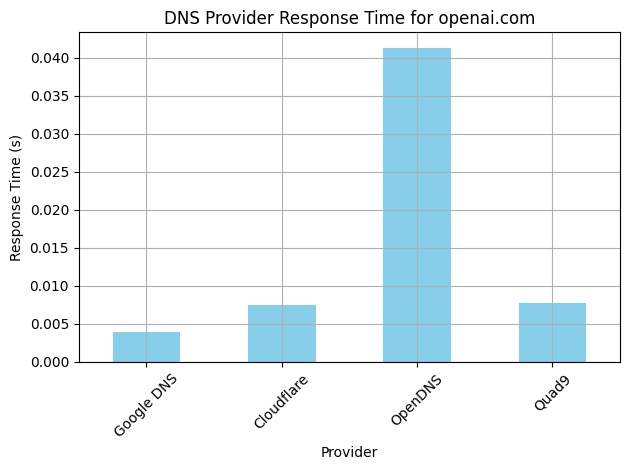

In [ ]:
import matplotlib.pyplot as plt

df.plot(kind='bar', x='Provider', y='Response Time (s)', legend=False, color='skyblue')
plt.ylabel('Response Time (s)')
plt.title(f'DNS Provider Response Time for {domain}')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Support For Additional DNS Record Types

In [ ]:
import dns.resolver

def resolve_dns(domain, record_type):
    resolver = dns.resolver.Resolver()
    try:
        answers = resolver.resolve(domain, record_type)
        return [str(rdata) for rdata in answers]
    except Exception as e:
        return [f"Error: {e}"]

record_types = ['A', 'AAAA', 'MX', 'TXT', 'CNAME', 'NS']
domain = input("Enter domain name: ")

for rtype in record_types:
    result = resolve_dns(domain, rtype)
    print(f"\n{rtype} Records for {domain}:")
    for r in result:
        print(" ", r)


Enter domain name: www.google.com

A Records for www.google.com:
  74.125.204.103
  74.125.204.105
  74.125.204.104
  74.125.204.99
  74.125.204.106
  74.125.204.147

AAAA Records for www.google.com:
  2404:6800:4008:c04::6a
  2404:6800:4008:c04::67
  2404:6800:4008:c04::93
  2404:6800:4008:c04::69

MX Records for www.google.com:
  Error: The DNS response does not contain an answer to the question: www.google.com. IN MX

TXT Records for www.google.com:
  Error: The DNS response does not contain an answer to the question: www.google.com. IN TXT

CNAME Records for www.google.com:
  Error: The DNS response does not contain an answer to the question: www.google.com. IN CNAME

NS Records for www.google.com:
  Error: The DNS response does not contain an answer to the question: www.google.com. IN NS


#TTL (Time-To-Live) Analysis

In [ ]:
import dns.resolver

def resolve_with_ttl(domain, record_type):
    try:
        answers = dns.resolver.resolve(domain, record_type)
        return [(str(rdata), r.ttl) for r in answers.response.answer for rdata in r.items]
    except Exception as e:
        return [("Error", str(e))]

record_types = ['A', 'AAAA', 'MX', 'TXT', 'NS']
domain = input("Enter domain name for TTL analysis: ")

for rtype in record_types:
    results = resolve_with_ttl(domain, rtype)
    print(f"\n{rtype} Records with TTL for {domain}:")
    for record, ttl in results:
        print(f"  Record: {record} | TTL: {ttl}")


Enter domain name for TTL analysis: www.google.com

A Records with TTL for www.google.com:
  Record: 142.251.170.104 | TTL: 300
  Record: 142.251.170.105 | TTL: 300
  Record: 142.251.170.103 | TTL: 300
  Record: 142.251.170.147 | TTL: 300
  Record: 142.251.170.99 | TTL: 300
  Record: 142.251.170.106 | TTL: 300

AAAA Records with TTL for www.google.com:
  Record: 2404:6800:4008:c01::69 | TTL: 300
  Record: 2404:6800:4008:c01::63 | TTL: 300
  Record: 2404:6800:4008:c01::6a | TTL: 300
  Record: 2404:6800:4008:c01::93 | TTL: 300

MX Records with TTL for www.google.com:
  Record: Error | TTL: The DNS response does not contain an answer to the question: www.google.com. IN MX

TXT Records with TTL for www.google.com:
  Record: Error | TTL: The DNS response does not contain an answer to the question: www.google.com. IN TXT

NS Records with TTL for www.google.com:
  Record: Error | TTL: The DNS response does not contain an answer to the question: www.google.com. IN NS


#Anomaly Detection And Alerts

In [ ]:
import dns.resolver
import time

def detect_anomalies(domain, record_types=['A', 'AAAA', 'MX', 'TXT'], response_time_threshold=1.5, low_ttl_threshold=60):
    resolver = dns.resolver.Resolver()
    anomalies = []

    for rtype in record_types:
        try:
            start = time.time()
            answer = resolver.resolve(domain, rtype, lifetime=3)
            elapsed = time.time() - start

            if elapsed > response_time_threshold:
                anomalies.append(f"High response time ({elapsed:.2f}s) for {rtype} record")

            for section in answer.response.answer:
                for rdata in section.items:
                    if hasattr(section, 'ttl') and section.ttl < low_ttl_threshold:
                        anomalies.append(f"Low TTL ({section.ttl}s) detected in {rtype} record")

        except Exception as e:
            anomalies.append(f"Error resolving {rtype} record: {e}")

    return anomalies

domain = input("Enter domain for anomaly check: ")
issues = detect_anomalies(domain)

if issues:
    print(f"\nAnomalies detected for {domain}:")
    for i in issues:
        print(" ", i)
else:
    print(f"No anomalies detected for {domain}.")


Enter domain for anomaly check: www.google.com

Anomalies detected for www.google.com:
  Error resolving MX record: The DNS response does not contain an answer to the question: www.google.com. IN MX
  Error resolving TXT record: The DNS response does not contain an answer to the question: www.google.com. IN TXT


#HOP Path Visualization

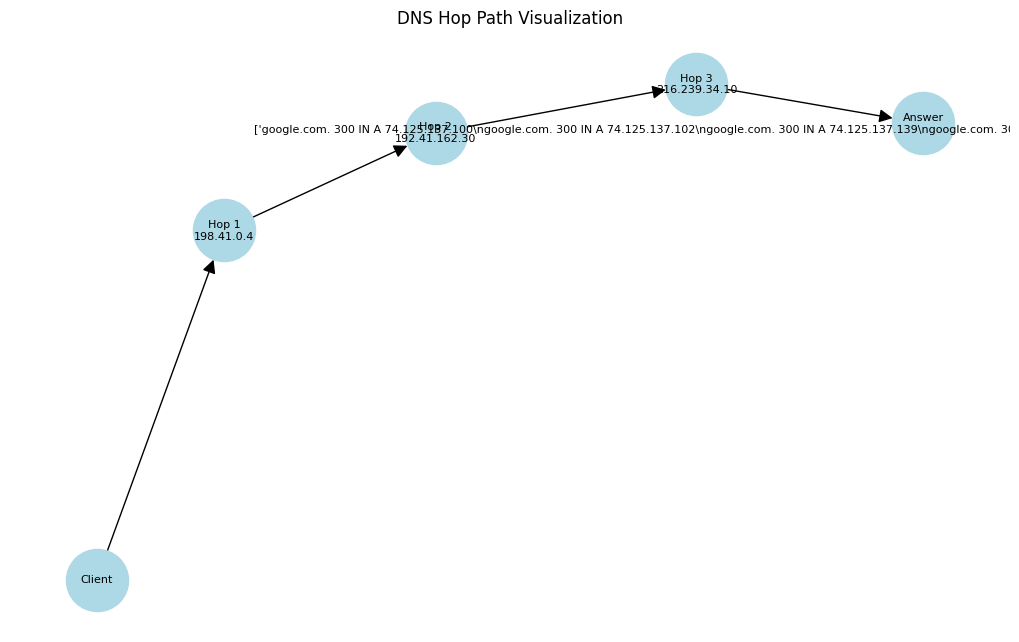

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv('dns_hops.csv')

G = nx.DiGraph()
prev_node = "Client"

for i, row in df.iterrows():
    server = f"Hop {row['Hop']}\n{row['DNS Server IP']}"
    G.add_node(server)
    G.add_edge(prev_node, server)
    prev_node = server

if 'Final Answer' in df.columns and df.iloc[-1]['Final Answer'] != "No Answer":
    final_node = f"Answer\n{df.iloc[-1]['Final Answer']}"
    G.add_node(final_node)
    G.add_edge(prev_node, final_node)

plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=8, arrowsize=20)
plt.title("DNS Hop Path Visualization")
plt.show()
